In [26]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import joblib
from sklearn.pipeline import Pipeline

In [27]:
df = pd.read_csv(r'../../resources/base_datos_tweets_ingles.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/02/2015 11:35,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/2015 11:15,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/02/2015 11:14,NaN,Pacific Time (US & Canada)


In [28]:
df = df[['airline_sentiment', 'text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [29]:
df['sentimiento'] = df['airline_sentiment'].map(
    {'positive': 'Positivo',
     'neutral': 'Neutro', 
     'negative': 'Negativo'
    })

df.head()

,airline_sentiment,text,sentimiento
0,neutral,@VirginAmerica What @dhepburn said.,Neutro
1,positive,@VirginAmerica plus you've added commercials t...,Positivo
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Neutro
3,negative,@VirginAmerica it's really aggressive to blast...,Negativo
4,negative,@VirginAmerica and it's a really big bad thing...,Negativo


In [30]:
round(df.value_counts('sentimiento', normalize=True), 2)

sentimiento
Negativo    0.63
Neutro      0.21
Positivo    0.16
Name: proportion, dtype: float64

In [31]:
df.drop(columns=['airline_sentiment'], inplace=True)

In [32]:
df.head()

,text,sentimiento
0,@VirginAmerica What @dhepburn said.,Neutro
1,@VirginAmerica plus you've added commercials t...,Positivo
2,@VirginAmerica I didn't today... Must mean I n...,Neutro
3,@VirginAmerica it's really aggressive to blast...,Negativo
4,@VirginAmerica and it's a really big bad thing...,Negativo


In [33]:
df.dropna(inplace=True)

In [34]:
df.isna().sum()

text           0
sentimiento    0
dtype: int64

In [35]:
corpus_entrenamiento, corpus_prueba, y_entrenamiento, y_prueba = train_test_split(
    df['text'],
    df['sentimiento'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['sentimiento'])


In [36]:
def print_distribution(name, series):
    series = pd.Series(series)
    dist = round(series.value_counts(normalize=True), 2)
    print(f"{name} Distribution:\n{dist}\n")

# Maintains the original Odyssey/Iliad ratio
print_distribution("Distribución Entrenamiento", y_entrenamiento)
print_distribution("Distribución Prueba", y_prueba)

Distribución Entrenamiento Distribution:
sentimiento
Negativo    0.63
Neutro      0.21
Positivo    0.16
Name: proportion, dtype: float64

Distribución Prueba Distribution:
sentimiento
Negativo    0.63
Neutro      0.21
Positivo    0.16
Name: proportion, dtype: float64



In [37]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')


# Eliminar stopwords y lematizar
stopword_list = set(stopwords.words('english'))

extra_stopwords = {
    "example", "etc", "also","used", "use",
    "one", "two", "like", "br", "much", "cup", "stuff",
    "day", "really", "read", "thing", "mouth",
    "day", "many", "still", "bag",
    "store", "case", "even", "item", "lot",
    "flight", "flights", "airline", "airlines", "plane", "planes", "delay", "delays", "fly", "seat", "seats",
    "without", "theyre", "soyive", "switchthe", "device"
    
}

stopword_list = stopword_list.union(extra_stopwords)


def procesar_texto_ingles(texto):
    """
    Función para limpiar y preprocesar texto en inglés.
    """
    # Manejo de valores nulos
    if not isinstance(texto, str):
        return ""

    # Eliminar HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()

    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)

    #Eliminar ususarios
    texto = re.sub(r'@\w+', '', texto)

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar caracteres no alfabéticos
    texto = re.sub(r"[^a-z\s]", "", texto)

    # Tokenizar
    tokens = word_tokenize(texto, language='english')

    # POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Lematizador
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    # Lematizar correctamente
    tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
        if word not in stopword_list and len(word) > 2
    ]

    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [38]:
corpus_entrenamiento_normalizado = [procesar_texto_ingles(text) for text in corpus_entrenamiento]
corpus_prueba_normalizado = [procesar_texto_ingles(text) for text in corpus_prueba]

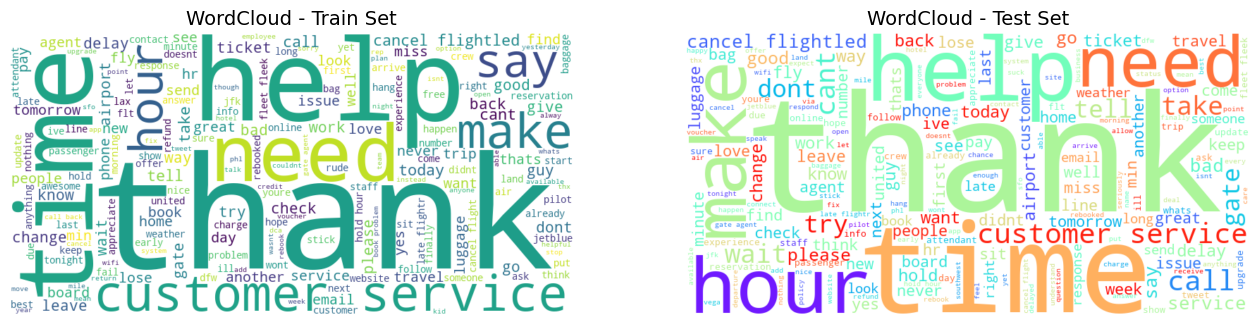

In [39]:
texto_entrenamiento = " ".join(corpus_entrenamiento_normalizado)
texto_prueba = " ".join(corpus_prueba_normalizado)

wc_train = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_entrenamiento)
wc_test = WordCloud(width=800, height=400, background_color="white", colormap="rainbow").generate(texto_prueba)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_train, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Train Set", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wc_test, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Test Set", fontsize=14)

plt.show()

In [40]:
vectorizer = TfidfVectorizer(
    norm= 'l2',
    smooth_idf= True,
    use_idf= True,
    ngram_range= (1,2), 
    max_df= 0.90,
    min_df= 2)

tfidf_matrix_entrenamiento = vectorizer.fit_transform(corpus_entrenamiento_normalizado)
tfidf_matrix_prueba = vectorizer.transform(corpus_prueba_normalizado)


In [41]:
np.unique(y_prueba)

array(['Negativo', 'Neutro', 'Positivo'], dtype=object)

In [42]:
def evaluacion_modelos(y_real, y_pred):
    
    labels = ['Negativo', 'Neutro', 'Positivo']

    print(f'Accuracy: {round(accuracy_score(y_real, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'F1-Score: {round(f1_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'Recall: {round(recall_score(y_real, y_pred, average= "weighted"),2)}')
    
    matriz_confusion_modelo = confusion_matrix(y_real, y_pred, normalize= "true")
    visualizacion_matriz_confusion = ConfusionMatrixDisplay(matriz_confusion_modelo, display_labels= labels)
    visualizacion_matriz_confusion.plot();
    print(classification_report(y_real, y_pred, target_names= labels))


In [43]:
tfidf_matrix_entrenamiento.shape, tfidf_matrix_prueba.shape

((11712, 11889), (2928, 11889))

In [44]:
modelo_lr = LogisticRegression(
    max_iter= 1000,
    random_state= 42,
    class_weight= 'balanced')

modelo_lr.fit(tfidf_matrix_entrenamiento, y_entrenamiento)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
y_pred_lr = modelo_lr.predict(tfidf_matrix_prueba)
y_proba_lr = modelo_lr.predict_proba(tfidf_matrix_prueba)

Accuracy: 0.76
Precision: 0.78
F1-Score: 0.76
Recall: 0.76
              precision    recall  f1-score   support

    Negativo       0.89      0.80      0.84      1835
      Neutro       0.54      0.68      0.60       620
    Positivo       0.66      0.68      0.67       473

    accuracy                           0.76      2928
   macro avg       0.69      0.72      0.70      2928
weighted avg       0.78      0.76      0.76      2928



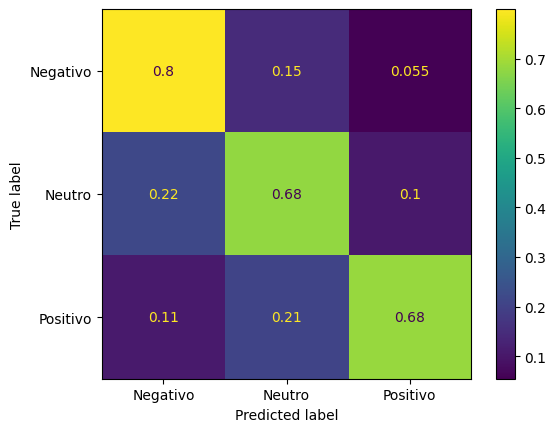

In [46]:
evaluacion_modelos(y_prueba,y_pred_lr)

In [47]:
modelo_nb = MultinomialNB(alpha = 1.0)
modelo_nb.fit(tfidf_matrix_entrenamiento,y_entrenamiento)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [48]:
y_pred_nb = modelo_nb.predict(tfidf_matrix_prueba)

Accuracy: 0.7
Precision: 0.73
F1-Score: 0.64
Recall: 0.7
              precision    recall  f1-score   support

    Negativo       0.69      0.99      0.82      1835
      Neutro       0.74      0.17      0.28       620
    Positivo       0.87      0.29      0.43       473

    accuracy                           0.70      2928
   macro avg       0.77      0.48      0.51      2928
weighted avg       0.73      0.70      0.64      2928



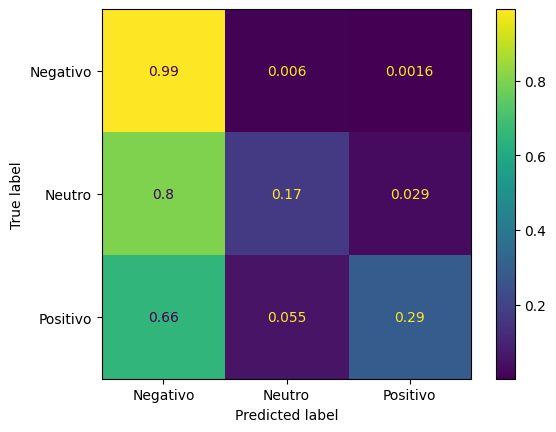

In [49]:
evaluacion_modelos(y_prueba,y_pred_nb)

In [50]:
modelos = {
    'Logistic Regression': y_pred_lr,
    'Naive Bayes': y_pred_nb
}

resultados = []

for nombre, pred in modelos.items():
    acc = accuracy_score(y_prueba, pred)
    prec = precision_score(y_prueba, pred, average='weighted')
    rec = recall_score(y_prueba, pred, average='weighted')
    f1 = f1_score(y_prueba, pred, average='weighted')
    
    resultados.append({
        'Modelo': nombre,
        'Exactitud': round(acc, 3),
        'Precisión': round(prec, 3),
        'Recall': round(rec, 3),
        'F1 Score': round(f1, 3)
    })

tabla_resultados = pd.DataFrame(resultados)

tabla_resultados.sort_values(by='Exactitud', ascending=False, inplace=True)
display(tabla_resultados)

,Modelo,Exactitud,Precisión,Recall,F1 Score
0,Logistic Regression,0.755,0.776,0.755,0.762
1,Naive Bayes,0.705,0.731,0.705,0.641


In [51]:
# Obtener coeficientes
feature_names = np.array(vectorizer.get_feature_names_out())
clases = modelo_lr.classes_

for i, clase in enumerate(clases):
    print(f"\n{'='*30}")
    print(f"SENTIMIENTO: {clase}")
    print(f"{'='*30}")
    
    # Top 15 palabras más importantes
    coefs = modelo_lr.coef_[i]
    top_indices = np.argsort(coefs)[-15:][::-1]
    top_features = feature_names[top_indices]
    top_coefs = coefs[top_indices]
    
    for feature, coef in zip(top_features, top_coefs):
        print(f"{feature:20s}: {coef:.4f}")


SENTIMIENTO: Negativo
hour                : 4.7312
delay               : 3.2110
bad                 : 3.0447
hold                : 2.8351
lose                : 2.7568
nothing             : 2.5509
cancel              : 2.5271
customer            : 2.5040
fail                : 2.4157
call                : 2.3840
hr                  : 2.3288
cant                : 2.1985
wait                : 2.1570
luggage             : 2.1559
rude                : 2.0991

SENTIMIENTO: Neutro
chance              : 1.5840
avgeek              : 1.5391
tomorrow            : 1.5236
march               : 1.4386
leave               : 1.4338
need                : 1.4144
flyingitforward     : 1.4053
possible            : 1.3173
destinationdragons  : 1.2830
dal                 : 1.2771
question            : 1.2457
currently           : 1.2397
current             : 1.2299
atlanta             : 1.1526
winner              : 1.1435

SENTIMIENTO: Positivo
great               : 5.1017
thanks              : 4.5960
thank

In [52]:
# Función para predecir
def predecir_sentimiento(texto, modelo=modelo_lr, vectorizer=vectorizer):
    # Vectorizar
    texto_tfidf = vectorizer.transform([texto])
    
    # Predecir
    prediccion = modelo.predict(texto_tfidf)[0]
    probabilidades = modelo.predict_proba(texto_tfidf)[0]
    
    # Crear resultado
    resultado = {
        'texto': texto,
        'sentimiento': prediccion,
        'probabilidad': max(probabilidades),
        'probabilidades_detalle': dict(zip(modelo.classes_, probabilidades))
    }
    
    return resultado

In [53]:
test_texts = [
    "I am not happy with the service, my issue is still unresolved.",
    "Great service today, the support agent was very helpful.",
    "I am not satisfied with this response.",
    "Okay service, nothing special.",
    "Not bad at all, the issue was fixed quickly."
]


for text in test_texts:
    resultado = predecir_sentimiento(text)
    print(f"\nTexto: {resultado['texto']}")
    print(f"Predicción: {resultado['sentimiento']}")
    print(f"Confianza: {resultado['probabilidad']:.2%}")
    print(f"Probabilidades: {resultado['probabilidades_detalle']}")
    print("-" * 60)


Texto: I am not happy with the service, my issue is still unresolved.
Predicción: Positivo
Confianza: 56.83%
Probabilidades: {'Negativo': np.float64(0.40744390411173803), 'Neutro': np.float64(0.02427352102142071), 'Positivo': np.float64(0.5682825748668413)}
------------------------------------------------------------

Texto: Great service today, the support agent was very helpful.
Predicción: Positivo
Confianza: 93.70%
Probabilidades: {'Negativo': np.float64(0.055349914439728816), 'Neutro': np.float64(0.007683952214915935), 'Positivo': np.float64(0.9369661333453554)}
------------------------------------------------------------

Texto: I am not satisfied with this response.
Predicción: Negativo
Confianza: 63.07%
Probabilidades: {'Negativo': np.float64(0.6306925322187871), 'Neutro': np.float64(0.07578809501684854), 'Positivo': np.float64(0.29351937276436446)}
------------------------------------------------------------

Texto: Okay service, nothing special.
Predicción: Negativo
Confianz

In [54]:
joblib.dump(modelo_lr, "modelo_sentimientos_ingles.pkl")
joblib.dump(vectorizer, "tfidf_vectorizador_ingles.pkl")

['tfidf_vectorizador_ingles.pkl']

In [56]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('modelo', LogisticRegression(max_iter=1000))
])

pipeline.fit(df['text'], df['sentimiento'])
joblib.dump(pipeline, "pipeline_sentimientos_ingles.pkl")


['pipeline_sentimientos_ingles.pkl']